In [17]:
import os, glob, math, random, json, time
import cv2
import numpy as np
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

In [ ]:
# ----------------------------
# Config 
# ----------------------------

train_image_dirs = ["DRIVE_AV/training/images", "DRIVE_AV/test/images","HRF_AV/test/images","HRF_AV/test/images"]

train_label_dirs = ["DRIVE_AV/training/label", "DRIVE_AV/test/label", "HRF_AV/test/label", "HRF_AV/test/label"]

train_mask_dirs  = ["DRIVE_AV/training/mask", "DRIVE_AV/test/mask","HRF_AV/test/mask","HRF_AV/test/mask"]

seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 4 classes: 0=background, 1=artery(red), 2=vein(blue), 3=crossing/uncertain(green)
NUM_CLASSES = 4

# BGR colors as OpenCV loads images in BGR
COLOR_MAP_BGR = {
    (0,   0,   0): 0,  # background
    (0,   0, 255): 1,  # red -> artery
    (255, 0,   0): 2,  # blue -> vein
    (0, 255,   0): 3,  # green -> crossing/uncertain
}
COLOR_TOL = 30  # tolerance for noisy labels

# ----------------------------
# Utilities
# ----------------------------
def list_image_triples(img_dirs, lbl_dirs, msk_dirs, exts=(".png", ".jpg", ".jpeg", ".tif")):
    paths = []
    name2label = {}
    name2mask = {}

    for d in lbl_dirs:
        for p in glob.glob(os.path.join(d, "**", "*"), recursive=True):
            if p.lower().endswith(exts):
                name2label[os.path.splitext(os.path.basename(p))[0]] = p

    for d in msk_dirs:
        for p in glob.glob(os.path.join(d, "**", "*"), recursive=True):
            if p.lower().endswith(exts):
                name2mask[os.path.splitext(os.path.basename(p))[0]] = p

    for d in img_dirs:
        for p in glob.glob(os.path.join(d, "**", "*"), recursive=True):
            if p.lower().endswith(exts):
                name = os.path.splitext(os.path.basename(p))[0]
                if name in name2label and name in name2mask:
                    paths.append((p, name2label[name], name2mask[name]))
    return sorted(paths)

def bgr_to_class(mask_bgr: np.ndarray, color_map=COLOR_MAP_BGR, tol=COLOR_TOL) -> np.ndarray:
    h, w, _ = mask_bgr.shape
    lab = np.zeros((h, w), dtype=np.uint8)
    mb = mask_bgr[...,0].astype(np.int16)
    mg = mask_bgr[...,1].astype(np.int16)
    mr = mask_bgr[...,2].astype(np.int16)
    assigned = np.zeros((h, w), dtype=bool)

    def assign(color_bgr, cls):
        nonlocal assigned, lab
        b,g,r = color_bgr
        cond = (np.abs(mb - b) <= tol) & (np.abs(mg - g) <= tol) & (np.abs(mr - r) <= tol) & (~assigned)
        lab[cond] = cls
        assigned[cond] = True

    # order: assign colored classes first, leave background last
    for c, cls in [((0,0,255),1), ((255,0,0),2), ((0,255,0),3)]:
        assign(c, cls)

    # remaining becomes background
    lab[~assigned] = 0
    return lab

def apply_green_CLAHE(img_bgr: np.ndarray, clip_limit=2.0, tile_grid_size=(8,8)) -> np.ndarray:
    # Enhance green channel with CLAHE (optionally denoise prior if desired)
    b,g,r = cv2.split(img_bgr)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    g_enh = clahe.apply(g)
    enhanced = cv2.merge([b, g_enh, r])
    return enhanced

In [19]:
# ----------------------------
# Dataset
# ----------------------------
class FundusAVDataset(Dataset):
    def __init__(self, triples, img_size=512, encoder='resnet34', augment=True):
        self.triples = triples
        self.img_size = img_size
        self.augment = augment

        # Preprocessing for encoder normalization
        self.preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, 'imagenet')

        # Albumentations pipelines
        self.train_tf = A.Compose([
            A.LongestMaxSize(max_size=img_size, interpolation=cv2.INTER_LINEAR),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=cv2.BORDER_REFLECT_101),
            A.OneOf([
                A.RandomResizedCrop(size=(img_size, img_size), scale=(0.75, 1.0), ratio=(0.9, 1.1), interpolation=cv2.INTER_LINEAR),
                A.CenterCrop(height=img_size, width=img_size),
            ], p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Affine(scale=(0.9, 1.1), rotate=(-20, 20), translate_percent=(0, 0.05), shear=(-5, 5), fit_output=True, p=0.75),
            A.OneOf([
                A.GridDistortion(num_steps=5, distort_limit=0.2, border_mode=cv2.BORDER_REFLECT_101, p=1.0),
                A.ElasticTransform(alpha=50, sigma=7, border_mode=cv2.BORDER_REFLECT_101, p=1.0),
            ], p=0.25),
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
                A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=15, val_shift_limit=15, p=1.0),
                A.CLAHE(clip_limit=(1.0, 4.0), tile_grid_size=(8,8), p=1.0),
            ], p=0.5),
            A.GaussianBlur(blur_limit=(3,5), p=0.15),
            A.GaussNoise(p=0.15),  # No var_limit
        ], additional_targets={'fov':'mask'})

        self.val_tf = A.Compose([
            A.LongestMaxSize(max_size=img_size, interpolation=cv2.INTER_LINEAR),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=cv2.BORDER_REFLECT_101),
            A.CenterCrop(height=img_size, width=img_size),
        ], additional_targets={'fov':'mask'})

        self.to_tensor = A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(transpose_mask=True),
        ], additional_targets={'fov':'mask'})

    def _normalize_for_encoder(self, x):
        x = x.astype(np.float32) / 255.0
        if self.preprocess_fn is not None:
            x = self.preprocess_fn(x)
        return x

    def __len__(self):
        return len(self.triples)

    def __getitem__(self, idx):
        img_p, lbl_p, fov_p = self.triples[idx]
        img = cv2.imread(img_p, cv2.IMREAD_COLOR)            # BGR
        lbl_rgb = cv2.imread(lbl_p, cv2.IMREAD_COLOR)        # BGR
        fov = cv2.imread(fov_p, cv2.IMREAD_GRAYSCALE)

        # Enhancement on image only
        img = apply_green_CLAHE(img, clip_limit=2.0, tile_grid_size=(8,8))

        # Convert label colors to class map
        lab = bgr_to_class(lbl_rgb)

        # Normalize FOV to {0,1}
        fov = (fov > 0).astype(np.uint8)

        # Albumentations (shared geo transforms)
        if self.augment:
            data = self.train_tf(image=img, mask=lab, fov=fov)
        else:
            data = self.val_tf(image=img, mask=lab, fov=fov)

        img, lab, fov = data["image"], data["mask"], data["fov"]

        # To tensors with encoder normalization
        data = self.to_tensor(image=img, mask=lab, fov=fov)
        img_t, lab_t, fov_t = data["image"], data["mask"].long(), data["fov"].float()
        return img_t, lab_t, fov_t, os.path.basename(img_p)

In [20]:
# ----------------------------
# Losses and metrics
# ----------------------------
class DiceLoss(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, eps=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.eps = eps

    def forward(self, logits, targets, fov):
        # logits: (B, C, H, W); targets: (B, H, W); fov: (B, 1, H, W) or (B, H, W)
        if fov.dim() == 3:
            fov = fov.unsqueeze(1)
        fov = (fov > 0.5).float()
        probs = F.softmax(logits, dim=1)
        targets_oh = F.one_hot(targets, num_classes=self.num_classes).permute(0,3,1,2).float()
        probs = probs * fov
        targets_oh = targets_oh * fov

        dims = (0,2,3)
        intersect = torch.sum(probs * targets_oh, dims)
        denom = torch.sum(probs + targets_oh, dims).clamp_min(self.eps)
        dice = (2.0 * intersect + self.eps) / (denom + self.eps)
        # exclude background from dice average
        # dice_fg = dice[:,1:].mean()
        dice_fg = dice[1:].mean()
        return 1.0 - dice_fg

class MaskedCrossEntropy(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight

    def forward(self, logits, targets, fov):
        # compute per-pixel CE, then mask by FOV and normalize
        ce = F.cross_entropy(logits, targets, weight=self.weight, reduction='none')
        if fov.dim() == 3:
            fov = fov.unsqueeze(1)
        fov = (fov.squeeze(1) > 0.5).float()
        ce = ce * fov
        denom = (fov>0.5).float().sum().clamp_min(1.0)
        return ce.sum() / denom

class ComboLoss(nn.Module):
    def __init__(self, ce_weight=None, alpha=0.5):
        super().__init__()
        self.ce = MaskedCrossEntropy(weight=ce_weight)
        self.dice = DiceLoss()
        self.alpha = alpha  # total = alpha * CE + (1-alpha) * Dice

    def forward(self, logits, targets, fov):
        return self.alpha * self.ce(logits, targets, fov) + (1.0 - self.alpha) * self.dice(logits, targets, fov)

def per_class_dice(logits, targets, fov, eps=1e-6):
    if fov.dim() == 3: fov = fov.unsqueeze(1)
    fov = (fov > 0.5).float()
    probs = F.softmax(logits, dim=1)
    targets_oh = F.one_hot(targets, num_classes=NUM_CLASSES).permute(0,3,1,2).float()
    probs, targets_oh = probs * fov, targets_oh * fov
    dims = (0,2,3)
    intersect = torch.sum(probs * targets_oh, dims)
    denom = torch.sum(probs + targets_oh, dims).clamp_min(eps)
    dice = (2.0 * intersect + eps) / (denom + eps)  # (C,)
    return dice.detach().cpu().numpy()  # per-class

In [21]:
# ----------------------------
# Model builder
# ----------------------------
def build_model(arch="unet", encoder="resnet34", classes=NUM_CLASSES, pretrained=True):
    encoder_weights = "imagenet" if pretrained else None
    if arch.lower() == "unet":
        model = smp.Unet(encoder_name=encoder, encoder_weights=encoder_weights, in_channels=3, classes=classes)
    elif arch.lower() in ["unet++", "unetplusplus", "unet_plus_plus"]:
        model = smp.UnetPlusPlus(encoder_name=encoder, encoder_weights=encoder_weights, in_channels=3, classes=classes, decoder_attention_type=None)
    else:
        raise ValueError("arch must be 'unet' or 'unet++'")
    return model

In [22]:
# ----------------------------
# Training loop
# ----------------------------
def train_model(arch="unet", encoder="resnet34", image_size=512, epochs=50, batch_size=4, lr=3e-4, val_split=0.2, pretrained=True, out_dir="./av_runs"):
    os.makedirs(out_dir, exist_ok=True)
    triples = list_image_triples(train_image_dirs, train_label_dirs, train_mask_dirs)
    print(f"Found {len(triples)} image/label/mask triples")

    dataset_full = FundusAVDataset(triples, img_size=image_size, encoder=encoder, augment=True)
    n_val = max(1, int(len(dataset_full)*val_split))
    n_train = len(dataset_full)-n_val
    ds_train, ds_val = random_split(dataset_full, [n_train, n_val], generator=torch.Generator().manual_seed(seed))
    # val dataset without strong augmentation
    ds_val.dataset.augment = False

    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
    val_loader   = DataLoader(ds_val,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    model = build_model(arch=arch, encoder=encoder, classes=NUM_CLASSES, pretrained=pretrained).to(device)

    # class weights (tune if needed): down-weight background
    ce_w = torch.tensor([0.2, 1.0, 1.0, 1.0], dtype=torch.float32, device=device)
    criterion = ComboLoss(ce_weight=ce_w, alpha=0.6)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_val = 0.0
    history = []

    for epoch in range(1, epochs+1):
        model.train()
        tr_loss, tr_dice = 0.0, np.zeros(NUM_CLASSES)
        for imgs, labs, fovs, _ in train_loader:
            imgs, labs, fovs = imgs.to(device), labs.to(device), fovs.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(imgs)
            loss = criterion(logits, labs, fovs)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            tr_loss += loss.item() * imgs.size(0)
            tr_dice += per_class_dice(logits, labs, fovs)

        tr_loss /= len(ds_train)
        tr_dice /= math.ceil(len(ds_train)/batch_size)

        model.eval()
        va_loss, va_dice = 0.0, np.zeros(NUM_CLASSES)
        with torch.no_grad():
            for imgs, labs, fovs, _ in val_loader:
                imgs, labs, fovs = imgs.to(device), labs.to(device), fovs.to(device)
                logits = model(imgs)
                loss = criterion(logits, labs, fovs)
                va_loss += loss.item() * imgs.size(0)
                va_dice += per_class_dice(logits, labs, fovs)

        va_loss /= len(ds_val)
        va_dice /= math.ceil(len(ds_val)/batch_size)
        scheduler.step()

        msg = {
            "epoch": epoch,
            "train_loss": round(tr_loss,5),
            "val_loss": round(va_loss,5),
            "dice_bg": round(float(va_dice[0]),4),
            "dice_artery": round(float(va_dice[1]),4),
            "dice_vein": round(float(va_dice[2]),4),
            "dice_cross": round(float(va_dice[3]),4),
            "lr": scheduler.get_last_lr()[0]
        }
        history.append(msg)
        print(msg)

        mean_fg = float(va_dice[1:].mean())
        if mean_fg > best_val:
            best_val = mean_fg
            torch.save({"model": model.state_dict(), "arch": arch, "encoder": encoder}, os.path.join(out_dir, "best.pt"))

    with open(os.path.join(out_dir, "history.json"), "w") as f:
        json.dump(history, f, indent=2)

    return model

In [23]:
# ----------------------------
# Inference and colorization
# ----------------------------
COLOR_PALETTE_BGR = {
    0: (0,0,0),
    1: (0,0,255),   # artery -> red in BGR order
    2: (255,0,0),   # vein -> blue
    3: (0,255,0),   # crossing/uncertain -> green
}

@torch.no_grad()
def predict_and_colorize(model, image_paths, out_dir="./av_runs/preds", image_size=512):
    os.makedirs(out_dir, exist_ok=True)
    model.eval()
    encoder = "resnet34"  # or whatever encoder you used for training
    preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, 'imagenet')

    for p in image_paths:
        img = cv2.imread(p, cv2.IMREAD_COLOR)
        img = apply_green_CLAHE(img)
        h, w = img.shape[:2]
        tf = A.Compose([
            A.LongestMaxSize(max_size=image_size, interpolation=cv2.INTER_LINEAR),
            A.PadIfNeeded(min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_REFLECT_101),
            A.CenterCrop(image_size, image_size),
            A.Lambda(image=lambda x: preprocess_fn(x.astype(np.float32)/255.0)),
            ToTensorV2()
        ])
        t = tf(image=img)["image"].unsqueeze(0).to(device)
        logits = model(t)
        probs = F.softmax(logits, dim=1)
        pred = probs.argmax(dim=1).squeeze(0).cpu().numpy().astype(np.uint8)

        # colorize
        color = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
        for cls, bgr in COLOR_PALETTE_BGR.items():
            color[pred==cls] = bgr

        # save
        base = os.path.splitext(os.path.basename(p))[0]
        cv2.imwrite(os.path.join(out_dir, f"{base}_av.png"), color)

In [24]:
# ----------------------------
# Run training (example)
# ----------------------------
if __name__ == "__main__":
    model = train_model(
        arch="unet++",       # "unet" or "unet++"
        encoder="resnet34",  # try "timm-efficientnet-b0" etc.
        image_size=512,
        epochs=20,
        batch_size=4,
        lr=3e-4,
        val_split=0.2,
        pretrained=True,
        out_dir="./av_runs"
    )
    # Example inference on a few images:
    some_images = [p for d in train_image_dirs for p in glob.glob(os.path.join(d, "*.jpg"))][:5]
    predict_and_colorize(model.to(device), some_images, out_dir="./av_runs/preds", image_size=512)


Found 46 image/label/mask triples
{'epoch': 1, 'train_loss': 0.51794, 'val_loss': 0.55886, 'dice_bg': 0.6177, 'dice_artery': 0.0927, 'dice_vein': 0.1335, 'dice_cross': 0.0048, 'lr': 0.00029815325108927063}
{'epoch': 2, 'train_loss': 0.44665, 'val_loss': 0.47871, 'dice_bg': 0.8102, 'dice_artery': 0.1608, 'dice_vein': 0.2695, 'dice_cross': 0.0061, 'lr': 0.00029265847744427303}
{'epoch': 3, 'train_loss': 0.40824, 'val_loss': 0.41827, 'dice_bg': 0.8866, 'dice_artery': 0.2752, 'dice_vein': 0.3552, 'dice_cross': 0.0125, 'lr': 0.0002836509786282552}
{'epoch': 4, 'train_loss': 0.37447, 'val_loss': 0.39281, 'dice_bg': 0.9136, 'dice_artery': 0.3281, 'dice_vein': 0.4388, 'dice_cross': 0.016, 'lr': 0.0002713525491562421}
{'epoch': 5, 'train_loss': 0.34865, 'val_loss': 0.377, 'dice_bg': 0.9305, 'dice_artery': 0.3915, 'dice_vein': 0.4586, 'dice_cross': 0.0215, 'lr': 0.0002560660171779821}
{'epoch': 6, 'train_loss': 0.32957, 'val_loss': 0.36797, 'dice_bg': 0.9387, 'dice_artery': 0.4182, 'dice_vein': 

In [25]:
from torch.utils.data import DataLoader, random_split

# Assuming you have this from before:
triples = list_image_triples(train_image_dirs, train_label_dirs, train_mask_dirs)
dataset_full = FundusAVDataset(triples, img_size=512, encoder='resnet34', augment=True)

# Split into train/val
val_split = 0.2
n_val = max(1, int(len(dataset_full)*val_split))
n_train = len(dataset_full) - n_val
ds_train, ds_val = random_split(dataset_full, [n_train, n_val], generator=torch.Generator().manual_seed(42))
# Turn off augmentation for validation set:
ds_val.dataset.augment = False

val_loader = DataLoader(ds_val, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)


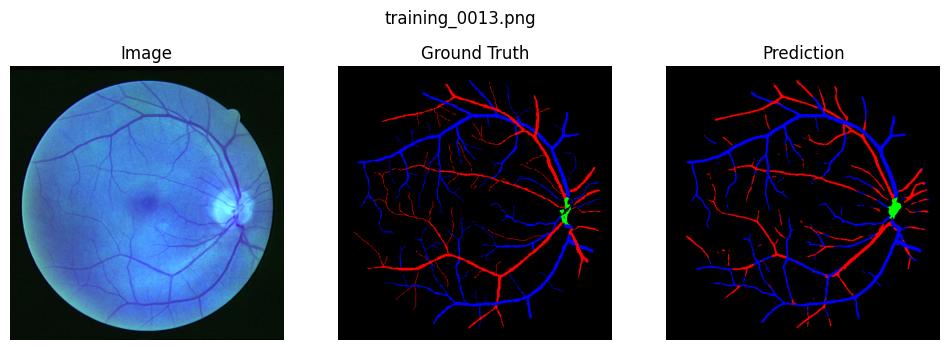

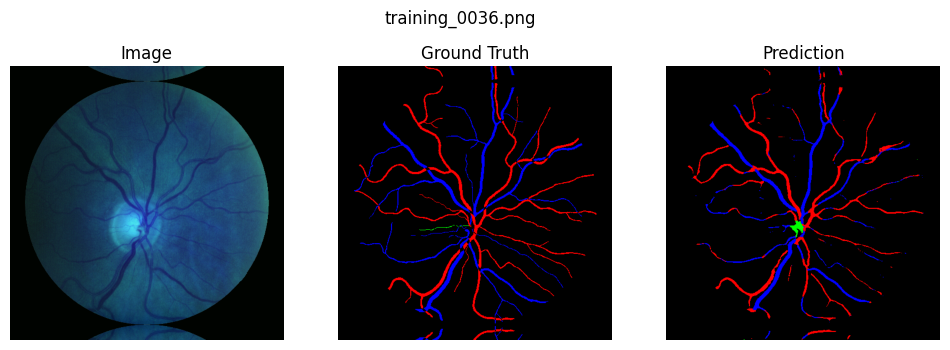

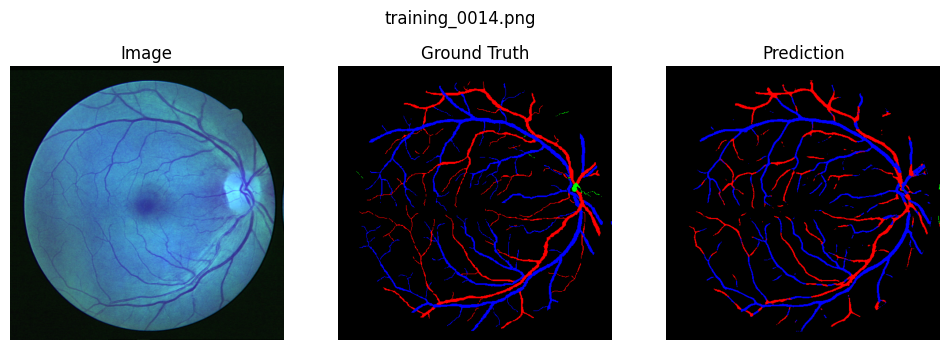

In [26]:
import matplotlib.pyplot as plt
import numpy as np
def colorize_mask(mask):
    COLOR_PALETTE = {
        0: (0, 0, 0),      # background (black)
        1: (255, 0, 0),    # artery (red)
        2: (0, 0, 255),    # vein (blue)
        3: (0, 255, 0),    # crossing/uncertain (green)
    }
    h, w = mask.shape
    color = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, rgb in COLOR_PALETTE.items():
        color[mask == cls] = rgb
    return color

# Get 3 samples from val_loader and plot
model.eval()
samples = []
with torch.no_grad():
    for imgs, labs, fovs, names in val_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = torch.argmax(torch.softmax(logits, dim=1), dim=1).cpu().numpy()
        labs = labs.cpu().numpy()
        imgs = imgs.cpu().numpy()
        for i in range(imgs.shape[0]):
            samples.append((imgs[i], labs[i], preds[i], names[i]))
            if len(samples) >= 3:
                break
        if len(samples) >= 3:
            break

# In your plotting loop (where you already load fovs)
for idx, (img, gt, pred, name) in enumerate(samples):
    img_disp = np.transpose(img, (1, 2, 0))
    img_disp = (img_disp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
    img_disp = np.clip(img_disp, 0, 1)
    fov_disp = fovs[idx]  # (H, W), values 0 (outside) or 1 (inside)
    # Ensure outside of FOV in prediction is set to background
    pred_masked = pred.copy()
    pred_masked[fov_disp == 0] = 0
    # For fairness, ground truth can also be masked (optional):
    gt_masked = gt.copy()
    gt_masked[fov_disp == 0] = 0

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_disp)
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(colorize_mask(gt_masked))
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(colorize_mask(pred_masked))
    plt.title('Prediction')
    plt.axis('off')
    plt.suptitle(name)
    plt.show()


In [27]:
def compute_iou_per_class(pred, target, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()
        if union == 0:
            ious.append(np.nan)  # ignore this class
        else:
            ious.append(float(intersection) / float(union))
    return ious

ious_all = []
model.eval()
with torch.no_grad():
    for imgs, labs, fovs, _ in val_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = torch.argmax(torch.softmax(logits, dim=1), dim=1).cpu().numpy()
        labs = labs.cpu().numpy()
        for i in range(preds.shape[0]):
            ious = compute_iou_per_class(preds[i], labs[i], num_classes=4)
            ious_all.append(ious)

ious_all = np.array(ious_all)  # shape: (N, 4)
mean_ious = np.nanmean(ious_all, axis=0)  # per-class MIoU
mean_miou = np.nanmean(mean_ious[1:])  # exclude background (class 0)

print(f"Per-class IoU: {mean_ious}")
print(f"Mean IoU (artery/vein/cross): {mean_miou:.4f}")


Per-class IoU: [0.68941745 0.40378524 0.34920291 0.00217733]
Mean IoU (artery/vein/cross): 0.2517
